> # Neural Network Basic - Week3 과제


In [22]:
from google.colab import drive

drive.mount('/home/contents/')

Drive already mounted at /home/contents/; to attempt to forcibly remount, call drive.mount("/home/contents/", force_remount=True).


In [23]:
import sys, os
os.chdir('/home/contents/MyDrive/Colab Notebooks/Tobigs 18/Week 3')

In [24]:
!ls

 dataset
 test_file.xlsx
 Tobigs18_Session_Week3_DecisionTree.ipynb
'Tobigs18_Session_Week3_Naiive Bayes.ipynb'
 week3_NeuralNetworkBasic_실습.ipynb


## Import Library

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [26]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [27]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## **Activation Function**
- sigmoid & relu : **hidden layer** activation function 
- softmax : **output layer** activation function
### **순전파**
- 뉴럴 네트워크 모델의 입력층부터 출력층까지 순서대로 변수들을 계산하고 저장하는 것을 의미
- 입력층에서 은닉층방향으로 이동하면서 각 입력에 해당하는 가중치가 곱해지고 결과적으로 가중치 합으로 계산되는 은닉층 뉴런의 함수 값이 입력됨.

### **역전파**
- input과 output값을 알고 있는 상태에서 신경망을 학습시키는 방법
- 순전파 알고리즘에서 발생한 오차를 줄이기 위해 새로운 가중치를 업데이트하고, 다시 학습하는 과정 
---

### **forward**
- In NN model, calculate whole variables from the model's input layer to output layer orderly
- an artificial neural network wherein connections between the nodes do not form a cycle. 
- the information moves in only one direction - forward- from the input nodes, through the hidden nodes. 
### **back propagation**
- Update the weights with the input value and output value so that we can reduce the loss from forward propagation algorithm. 
- Trainin feedfoward neural network 


#### **sigmoid**
- 시그모이드함수는 다음과 같이 정의
$$sigmoid(x) =  \frac{1}{1+e^{-x}}$$
- 0에서 1사이의 함수로, 0과 1에 가까운 값을 통해 **이진분류**하는데 사용
- (pros) 0과 1로 나뉘어 출력값이 어느값에 가까운지를 통해 어느 분류에 속하는지 쉽게 파악
- (cons) 접선의 기울기가 saturated 되는 경향이 있어 **gradient vanishing 문제**가 생길 수 있음. 
    - 미분계수의 최대값이 0.25로 back-propagation을 계산하는 과정에서 미분 계수의 영향을 적게 받기 때문에 은닉층의 깊이가 깊으면 계산이 어려움. 

In [29]:
class sigmoid:
    def forward(x):
        return 1/(1+np.exp(-x))
    
    def backward(x):
        # 시그모이드 함수 미분 
        return x*(1-x)

#### **relu**
- relu함수는 다음과 같이 정의
$$relu(x) = \begin{cases}x & x > 0\\0 & x  \leq  0\end{cases}$$
- (pros) 학습이 빠르고 연산비용이 적어 구현이 간단
- (cons) 0보다 작은 값들은 모두 0으로 만들어 뉴런이 죽을 수도 있음. 

In [20]:
class relu:
    def forward(x):
        return np.maximum(0, x)
    
    def backward(x):
        return np.where(x>0, 1, 0)

### **softmax**
- softmax 함수는 다음과 같이 정의됨.
- k 차원의 벡터에서 i번째 원소를 $z_i$, i번째 클래스가 정답일 확률을 $p_i$라고 나타낸다면 소프트맥스 함수는 $p_i$라고 정의함. 
$$p_i =  \frac{e^{z_i}}{ \sum_{j=1}^k e^{z_j}}$$
#### forward
- To make our softmax function numerically stable, we normalize the values in the vector by multiplying the numerator and denominator with a constant C. 
    - usually $log(C) = -max(a)$
    



In [30]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            # 1. In case the elements of the input array are very large, subtracting the maximum value in the array from every value of the array 
            c = np.max(zi)
            exp_zi = np.exp(zi-c)

            # 2. denominator
            sum_exp_zi = np.sum(exp_zi)

            # 3. calculate 
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi : # 정답값과 동일하다면 
                    dpi[k] -= 1 # 
        return dp

## Loss Function

In [31]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) # avoid divide by zero error 
    return loss

## Layer

In [32]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [36]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr # 학습률
        self.epoch = epoch  # epoch
        self.batch_size = batch_size # 모델이 한번에 학습하고자하는 데이터의 사이즈 

        self.loss_function = cross_entropy # 비용함수는 cross entropy 
        self.layers = [] # layer 배열
        
        self.activations = [softmax] # 활성함수는 softmax
        self.nodes = [] 
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) # 입력받는 Layer 추가
        if not self.nodes: # node가 없다면 (초기화)
            self.nodes.append(np.zeros(Layer.input_size)) # input size에 대한 정보 추가 
        self.nodes.append(np.zeros(Layer.output_size)) # output 노드의 수를 추가
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() # 뒤에 있는 활성함수 pop : softmax
        self.activations.append(Activation)  # 활성함수 추가
        self.activations.append(tmp) # 다시 tmp 넣어줌 
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() # 입력받은 X로 첫번째 노드 초기화
        output = X.copy() # ouput에 X copy
        for i in range(len(self.layers)): 
            # 1. 데이터 로드 
            Layer = self.layers[i] # 반복할 Layer 
            Activation = self.activations[i] # 활설함수

            # 2. 예측값 연산 (1) 가중치 행렬 곱 (2) 편향값 더하기 
            output = np.dot(self.nodes[i], Layer.weight) # node와 가중치를 행렬곱 
            output = output+ Layer.bias # 편향값 더하기 
    
            # 3. 활성함수 적용 
            output = Activation.forward(output) 
            
            # 4. 다음번 노드의 결과값으로 초기화 
            self.nodes[i+1] = output 

        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): # 역전파이므로 back에서 진행 
            a = self.nodes[i+1]  # 다음 레이어의 값
            Layer = self.layers[i] # 현재 레이어의 값 
            Activation = self.activations[i]  # 해당 레이어의 활성함수 
            
            if i+1 == len(self.layers): # softmax 함수의 경우 
                error = Activation.backward(output, y) 
            else: # relu or sigmoid 
                error *= Activation.backward(a)

            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] # 가중치 업데이트
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0] # 편향값 업데이트

            error = np.dot(error, Layer.weight.T) # 에러값 계산 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) # 가장 높은 값을 갖는 인덱스 반환 (예측값)
        return np.sum(pre_p==y)/y.shape[0] # 정확도 계산 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):
            for j in range(N//self.batch_size): 
                batch_mask = np.random.choice(N, self.batch_size) # batch size만큼 랜덤하게 N개의 mask 선택 
                # x값과 y값 선언 
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 

                output = self._forward(X_batch) # batch 데이터 forward
                self._backward(X_batch, output, y_batch) # backwar -> 업데이트 
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) # 정확도 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) # 손실율
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [33]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [34]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [35]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1032
0 test loss     : 23051.435618705647
10 test accuracy : 0.1138
10 test loss     : 22929.714335638222
20 test accuracy : 0.1537
20 test loss     : 22802.747863950117
30 test accuracy : 0.178
30 test loss     : 22495.362899875414
40 test accuracy : 0.1986
40 test loss     : 21601.565209659835
50 test accuracy : 0.2963
50 test loss     : 20088.968954640466
60 test accuracy : 0.3073
60 test loss     : 18780.420949814732
70 test accuracy : 0.4049
70 test loss     : 17691.737450620454
80 test accuracy : 0.4727
80 test loss     : 16253.833383977088
90 test accuracy : 0.5304
90 test loss     : 14405.532975882
100 test accuracy : 0.6126
100 test loss     : 12778.708951329634
110 test accuracy : 0.6891
110 test loss     : 11225.864041458139
120 test accuracy : 0.7463
120 test loss     : 9704.590325754396
130 test accuracy : 0.7775
130 test loss     : 8482.741982205192
140 test accuracy : 0.7996
140 test loss     : 7575.473313188656
150 test accuracy : 0.8185
150 test los

## Accuracy, Loss Visualization

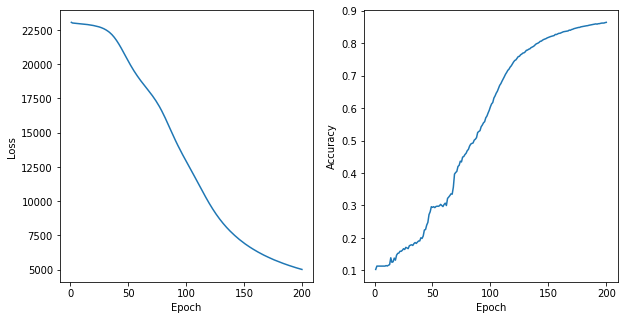

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(np.arange(1,201),history['val_loss'])
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(np.arange(1,201), history['val_acc'])
plt.show()